## Beautiful Demo

Loads training data and shows an example training face

In [1]:
from matplotlib import pyplot as plt
from read_data import training_validation

from time import time
from random import choice

(training_images, training_labels), (test_images, test_labels) = training_validation()

sample_image_positive = choice(training_images)
sample_image_negative = choice(test_images)

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(sample_image_positive)
ax2.imshow(sample_image_negative)
plt.show()



reading csv: 4.044411897659302
formatting to numpy matrices: 3.9594500064849854
picking random data: 0.008246660232543945
Formatting data: 2.8133392333984375e-05


## Example of feature selection used

5395.0
-14039.0
21408.0
108690.0
99208.0


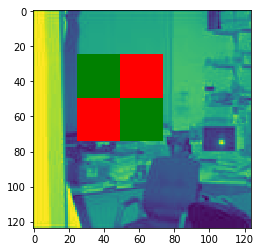

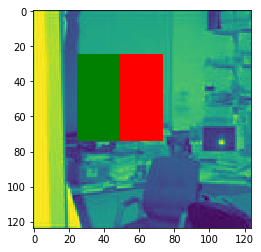

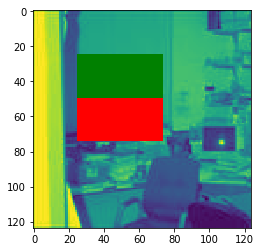

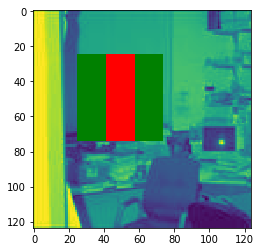

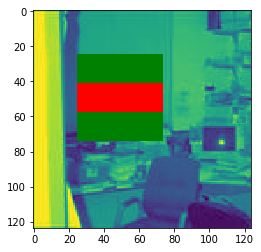

In [2]:
from features import *
from processing import IntegralImage

fsize = FeatureSize(0.2, 0.2, 0.4, 0.4)
ii = IntegralImage(sample_image_positive)
ii.process()

f = Feature(fsize, A)
fig, ax1 = plt.subplots(1, 1)
f.print_feature(ii, ax1)
print(f.calculate(ii))

f = Feature(fsize, B1)
fig, ax1 = plt.subplots(1, 1)
f.print_feature(ii, ax1)
print(f.calculate(ii))

f = Feature(fsize, B2)
fig, ax1 = plt.subplots(1, 1)
f.print_feature(ii, ax1)
print(f.calculate(ii))

f = Feature(fsize, C1)
fig, ax1 = plt.subplots(1, 1)
f.print_feature(ii, ax1)
print(f.calculate(ii))

f = Feature(fsize, C2)
fig, ax1 = plt.subplots(1, 1)
f.print_feature(ii, ax1)
print(f.calculate(ii))


plt.show()

## Example of Feature Generation

In [3]:
from features import *
count = 0
for sz in generate_all_sizes():
    count += 1
print(count)

225


## Format training and test data

The format is adapted for the special ada boosted version, to extract features, therefore to train the normal bayes
we have to transpose the data to get image x features instead of features x images.

In [4]:
import processing
import features
import os
from numpy import save, load


training = None
test = None
all_features = features.generate_all_features()
if not os.path.isfile("training_feature_matrix.npy") or True:

    IItraining = processing.bulk_II(training_images)
    IItest = processing.bulk_II(test_images)

    training = features.get_feature_matrix(IItraining, all_features)
    test = features.get_feature_matrix(IItest, all_features)

    """ _ is same as above. """

    save("training_feature_matrix", training)
    save("test_feature_matrix", test)
else:
    training = load("training_feature_matrix.npy")
    test = load("test_feature_matrix.npy")
    
training_for_bayes = training[500:510].T
test_for_bayes = test[500:510].T

Generate all features: 0.0009768009185791016
Processing all integral images: 46.295143842697144
Processing all integral images: 46.99194598197937
get feature matrix: 12.44272518157959
get feature matrix: 11.742389917373657


## Testing Naive Bayes 

Naive bayes based on Normal distribution

10626.0
29996.0


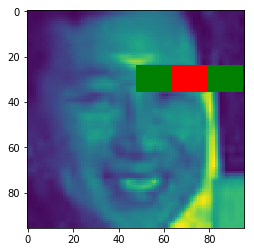

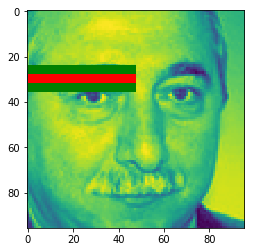

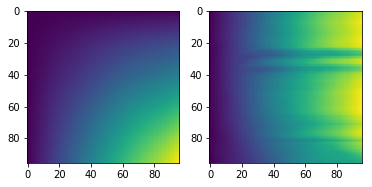

In [5]:
feature508 = all_features[508]

fig, ax1 = plt.subplots(1,1)

feature508.print_feature(IItraining[0], ax1)
print(feature508.calculate(IItraining[0]))

feature508 = all_features[504]

fig, ax1 = plt.subplots(1,1)

feature508.print_feature(IItraining[2], ax1)
print(feature508.calculate(IItraining[2]))
fig, (ax2, ax3) = plt.subplots(1, 2)
ax2.imshow(IItraining[2].ii)
ax3.imshow(IItraining[2].ss)

plt.show()


In [6]:
from naive_bayes import naive_bayes
from numpy import array, save
from sys import stdout


classifier = naive_bayes()
training_labels = array(training_labels)
print(training_labels)

classifier.train(training_for_bayes, training_labels)
correct = 0
total = len(test_for_bayes)
print(total)

false_positive = None
false_negative = None

false_positives = 0
false_negatives = 0 
for index, image in enumerate(test_for_bayes):
    #stdout.write("\r\r\r" + str(index) + str("\r\r\r"))
    
    prediction = classifier.predict(image)
    print("label", test_labels[index])
    print("pred", prediction)

    label = test_labels[index]
  
    
    false_positives += (prediction == 1 and label == 0)
    false_negatives += (prediction == 0 and label == 1)
    
    if prediction == 1 and label == 0:
        false_positive = test_images[index]
    
    if prediction == 0 and label == 0:
        false_negative = test_images[index]
        
    is_correct = prediction == label
    correct += is_correct
    

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

pred 1
determinant 3.63653833156e+86
determinant 3.62410570068e+74
label 1
pred 1
determinant 3.63653833156e+86
determinant 3.62410570068e+74
label 1
pred 1
determinant 3.63653833156e+86
determinant 3.62410570068e+74
label 1
pred 1
determinant 3.63653833156e+86
determinant 3.62410570068e+74
label 1
pred 1
determinant 3.63653833156e+86
determinant 3.62410570068e+74
label 1
pred 1
determinant 3.63653833156e+86
determinant 3.62410570068e+74
label 1
pred 1
determinant 3.63653833156e+86
determinant 3.62410570068e+74
label 1
pred 1
determinant 3.63653833156e+86
determinant 3.62410570068e+74
label 1
pred 1
determinant 3.63653833156e+86
determinant 3.62410570068e+74
label 1
pred 1
determinant 3.63653833156e+86
determinant 3.62410570068e+74
label 1
pred 1
determinant 3.63653833156e+86
determinant 3.62410570068e+74
label 1
pred 1
determinant 3.63653833156e+86
determinant 3.62410570068e+74
label 1
pred 1
determinant 3.63653833156e+86
determinant 3.62410570068e+74
label 1
pred 1
determinant 3.6365

pred 1
determinant 3.63653833156e+86
determinant 3.62410570068e+74
label 1
pred 1
determinant 3.63653833156e+86
determinant 3.62410570068e+74
label 1
pred 1
determinant 3.63653833156e+86
determinant 3.62410570068e+74
label 1
pred 1
determinant 3.63653833156e+86
determinant 3.62410570068e+74
label 1
pred 1
determinant 3.63653833156e+86
determinant 3.62410570068e+74
label 1
pred 1
determinant 3.63653833156e+86
determinant 3.62410570068e+74
label 1
pred 0
determinant 3.63653833156e+86
determinant 3.62410570068e+74
label 1
pred 1
determinant 3.63653833156e+86
determinant 3.62410570068e+74
label 1
pred 1
determinant 3.63653833156e+86
determinant 3.62410570068e+74
label 1
pred 1
determinant 3.63653833156e+86
determinant 3.62410570068e+74
label 1
pred 1
determinant 3.63653833156e+86
determinant 3.62410570068e+74
label 1
pred 1
determinant 3.63653833156e+86
determinant 3.62410570068e+74
label 1
pred 1
determinant 3.63653833156e+86
determinant 3.62410570068e+74
label 0
pred 0
determinant 3.6365

pred 0
determinant 3.63653833156e+86
determinant 3.62410570068e+74
label 0
pred 1
determinant 3.63653833156e+86
determinant 3.62410570068e+74
label 0
pred 0
determinant 3.63653833156e+86
determinant 3.62410570068e+74
label 0
pred 0
determinant 3.63653833156e+86
determinant 3.62410570068e+74
label 0
pred 0
determinant 3.63653833156e+86
determinant 3.62410570068e+74
label 0
pred 0
determinant 3.63653833156e+86
determinant 3.62410570068e+74
label 0
pred 0
determinant 3.63653833156e+86
determinant 3.62410570068e+74
label 0
pred 0
determinant 3.63653833156e+86
determinant 3.62410570068e+74
label 0
pred 0
determinant 3.63653833156e+86
determinant 3.62410570068e+74
label 0
pred 1
determinant 3.63653833156e+86
determinant 3.62410570068e+74
label 0
pred 0
determinant 3.63653833156e+86
determinant 3.62410570068e+74
label 0
pred 1
determinant 3.63653833156e+86
determinant 3.62410570068e+74
label 0
pred 1
determinant 3.63653833156e+86
determinant 3.62410570068e+74
label 0
pred 1
determinant 3.6365

In [7]:
print(correct)
print(false_positives)
print(false_negatives)

777
160
13


In [8]:
print(correct / total)

0.8178947368421052
